In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torch torchvision


In [3]:
import warnings
warnings.filterwarnings("ignore") 
import shutil
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [4]:
import torch
import time
from tqdm import tqdm
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from torchvision import models
from torchvision.transforms import transforms
from torchvision.models import resnet18, vgg16
from torch.nn import Linear, CrossEntropyLoss

### Importing EuroSAT-RGB dataset with 5 classes

In [5]:
# importing eurosat data which contains only 5 categories
eurosat_data = '/kaggle/input/eurosat-rgb-5-categories/EuroSAT_RGB'
# # for dirname, _, filenames in os.walk('/kaggle/input'):
# #     for filename in filenames:
# #         print(os.path.join(dirname, filename))
for dirname in os.listdir(eurosat_data):
    print(dirname, len(os.listdir(os.path.join(eurosat_data,dirname))))

categories = os.listdir(eurosat_data)

print(f"Categories: {len(categories)}")

SeaLake 3000
Highway 2500
River 2500
AnnualCrop 3000
Forest 3000
Categories: 5


### Choosing 20 images per class form EuroSAT data for training
### Rest of them are for test and validation

In [6]:
import random
import shutil


output_path = '/kaggle/working/eurosat-rgb-sample/'
for category in categories:
    category_path = os.path.join(eurosat_data, category)
    
    print(f'category path: {category_path}')
    #print(os.listdir(category_path)[0])
    images = []
    # taking 20 images from the category randomly
    for i in range(20):
        images.append(os.listdir(category_path)[random.randint(0, len(os.listdir(category_path)))])
    
    print(images)
    # splitting the selected 20 images in train and rest
    os.makedirs(os.path.join(output_path, 'train', category), exist_ok=True)
    train, rest = train_test_split(images, test_size=0.75, random_state=0)
    val, test = train_test_split(rest, test_size=0.8, random_state=0)
    
    print(f"train size:{len(train)} ")
    print(f"test size:{len(test)} ")
    print(f"val size:{len(val)} ")
    # saving them separetely under the output path
    os.makedirs(os.path.join(output_path, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'test', category), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'val', category), exist_ok=True)
#     os.makedirs(os.path.join(output_path, 'test', category), exist_ok=True)

    for img in train:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'train', category, img))
    for img in test:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'test', category, img))
    for img in val:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'val', category, img))

category path: /kaggle/input/eurosat-rgb-5-categories/EuroSAT_RGB/SeaLake
['SeaLake_2678.jpg', 'SeaLake_13.jpg', 'SeaLake_1831.jpg', 'SeaLake_2712.jpg', 'SeaLake_2088.jpg', 'SeaLake_2002.jpg', 'SeaLake_103.jpg', 'SeaLake_1853.jpg', 'SeaLake_252.jpg', 'SeaLake_2431.jpg', 'SeaLake_790.jpg', 'SeaLake_1420.jpg', 'SeaLake_404.jpg', 'SeaLake_1199.jpg', 'SeaLake_822.jpg', 'SeaLake_2012.jpg', 'SeaLake_1280.jpg', 'SeaLake_1036.jpg', 'SeaLake_1611.jpg', 'SeaLake_2513.jpg']
train size:5 
test size:12 
val size:3 
category path: /kaggle/input/eurosat-rgb-5-categories/EuroSAT_RGB/Highway
['Highway_2152.jpg', 'Highway_1165.jpg', 'Highway_1088.jpg', 'Highway_1949.jpg', 'Highway_960.jpg', 'Highway_229.jpg', 'Highway_574.jpg', 'Highway_2156.jpg', 'Highway_2100.jpg', 'Highway_1892.jpg', 'Highway_404.jpg', 'Highway_673.jpg', 'Highway_2245.jpg', 'Highway_162.jpg', 'Highway_694.jpg', 'Highway_1751.jpg', 'Highway_2412.jpg', 'Highway_1622.jpg', 'Highway_1162.jpg', 'Highway_998.jpg']
train size:5 
test size:1

### Image trainsformations and loading data in DataLoader

In [7]:
from torchvision.datasets import ImageFolder

BATCH_SIZE = 32 
# NUM_EPOCHS = 10
# LEARNING_RATE = 1e-3
criterion = nn.CrossEntropyLoss()

train_path = '/kaggle/working/eurosat-rgb-sample/train/'
val_path = '/kaggle/working/eurosat-rgb-sample/val/'
test_path = '/kaggle/working/eurosat-rgb-sample/test/'

transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Defining model training function

In [8]:
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, early_stopping_patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        print(f"{torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model.to(device)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    early_stopping_counter = 0
    best_val_loss = float('inf')
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)
    
    for epoch in range(num_epochs):
        model.train()
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_progress_bar.set_postfix(loss=loss.item())
            
        train_accuracy = correct / total
        average_loss = running_loss / len(train_loader)
        
        train_losses.append(average_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        
        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                val_progress_bar.set_postfix(loss=loss.item())

            val_accuracy = correct / total
            avg_val_loss = val_loss/len(val_loader)
            
            scheduler.step(avg_val_loss)
        
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping after {epoch + 1} epochs without improvement in validation loss.")
                break
            
    return train_losses, train_accuracies, val_losses, val_accuracies

### Defining model testing function

In [9]:
def test_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        print(f"{torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    test_loss = 0
    test_progress_bar = tqdm(test_loader, desc='Testing')
    
    with torch.no_grad():
        for inputs, labels in test_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            batch_accuracy = predicted.eq(labels).sum().item() / labels.size(0)
            test_progress_bar.set_postfix(batch_accuracy=f'{batch_accuracy:.4f}')
    
    avg_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return avg_loss, test_accuracy

### Defining model training visualization

In [10]:
def training_loss_vis(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # Training vs Validation Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Training vs Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### VGG16 architechture for 5 classes
### Removed the last layer of the previously trained model which contains 64 output classes
### Adding the new last layer with 5 classes as our selected dataset

In [11]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

class VGG16(nn.Module):
    def __init__(self, NUM_CLASSES):
        super(VGG16, self).__init__()
        self.vgg16 = vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features

        # Create a new Linear layer with the correct number of output features
        self.vgg16.classifier[6] = nn.Linear(in_features, NUM_CLASSES)

    def forward(self, x):
        return self.vgg16(x)

# Example usage
NUM_CLASSES = 5  # Number of classes in your new dataset
vgg16_model = VGG16(NUM_CLASSES).to(device)

# Load the pretrained weights into the model
pretrained_model_path = '/kaggle/input/vgg16-pre/VGG16_model.pth'
pretrained_dict = torch.load(pretrained_model_path, map_location=device)
#print("Keys in pretrained state dictionary:", pretrained_dict.keys())
# Extract the weights for the last fully connected layer from the pretrained model
pretrained_fc_weights = pretrained_dict['vgg16.classifier.6.weight']
pretrained_fc_bias = pretrained_dict['vgg16.classifier.6.bias']

# Get the weights and bias for the last fully connected layer in your current model
current_fc_weights = vgg16_model.vgg16.classifier[6].weight
current_fc_bias = vgg16_model.vgg16.classifier[6].bias

# Update the weights and bias in the current model
vgg16_model.vgg16.classifier[6].weight.data = pretrained_fc_weights[:NUM_CLASSES, :]
vgg16_model.vgg16.classifier[6].bias.data = pretrained_fc_bias[:NUM_CLASSES]



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 257MB/s]  


In [14]:
NUM_EPOCHS = 500
LEARNING_RATE = 0.0001
optimizer = optim.RMSprop(vgg16_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
train_losses, train_accuracies, val_losses, val_accuracies = train_model(vgg16_model, train_loader, val_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)



2 GPUs!


Epoch 1/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, loss=2.08]


Epoch 1/500, Training Loss: 2.0454, Training Accuracy: 0.2400, Validation Loss: 2.0815, Validation Accuracy: 0.2000


Epoch 2/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s, loss=11.4]


Epoch 2/500, Training Loss: 1.9606, Training Accuracy: 0.2800, Validation Loss: 11.4328, Validation Accuracy: 0.2000


Epoch 3/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s, loss=1.81]


Epoch 3/500, Training Loss: 12.2550, Training Accuracy: 0.2000, Validation Loss: 1.8106, Validation Accuracy: 0.2000


Epoch 4/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s, loss=1.61]


Epoch 4/500, Training Loss: 1.9684, Training Accuracy: 0.2000, Validation Loss: 1.6081, Validation Accuracy: 0.2000


Epoch 5/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, loss=1.61]


Epoch 5/500, Training Loss: 1.6659, Training Accuracy: 0.2400, Validation Loss: 1.6070, Validation Accuracy: 0.1333


Epoch 6/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s, loss=1.52]


Epoch 6/500, Training Loss: 1.5939, Training Accuracy: 0.2000, Validation Loss: 1.5238, Validation Accuracy: 0.4000


Epoch 7/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s, loss=3.23]


Epoch 7/500, Training Loss: 1.4922, Training Accuracy: 0.4800, Validation Loss: 3.2310, Validation Accuracy: 0.2000


Epoch 8/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s, loss=2.01]


Epoch 8/500, Training Loss: 3.0339, Training Accuracy: 0.2400, Validation Loss: 2.0130, Validation Accuracy: 0.2000


Epoch 9/500 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s, loss=1.64]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 9/500, Training Loss: 1.9038, Training Accuracy: 0.2000, Validation Loss: 1.6359, Validation Accuracy: 0.2000
Early stopping after 9 epochs without improvement in validation loss.


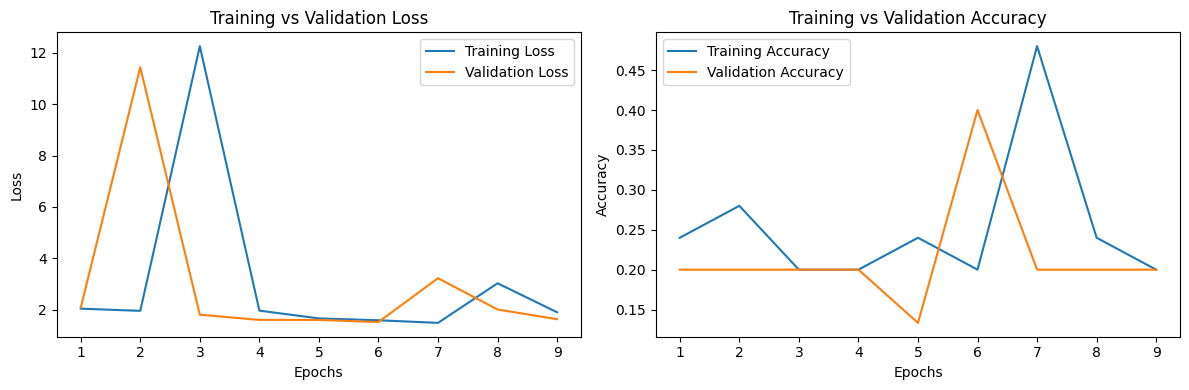

In [15]:
training_loss_vis(train_losses, val_losses, train_accuracies, val_accuracies)

In [16]:
test_model(vgg16_model, test_loader, criterion)

2 GPUs!


Testing: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s, batch_accuracy=0.0000]

Test Loss: 1.6494, Test Accuracy: 0.1500


(1.6494077444076538, 0.15)

In [ ]:
torch.save(model.state_dict(), 'VGG16_model_transfer.pth')
torch.save(model, 'VGG16_wmodel_transfer.pth')

### ResNet18 architechture definition
### Removing the  last layer from previously trained model as it contained 64 classes
### Adding the last layer of 5 classes

In [17]:
class ResNet18(nn.Module):
    def __init__(self, NUM_CLASSES):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        for param in self.resnet18.parameters():
            param.requires_grad = False
        in_features = self.resnet18.fc.in_features

        # Removing the last layer
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-1])

        # new last layer for your specific number of classes
        self.fc = nn.Linear(in_features, NUM_CLASSES)

    def forward(self, x):
        x = self.resnet18(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create the model
resnet18_model = ResNet18(NUM_CLASSES).to(device)

# Load weights from the saved model (excluding the last layer)
model_path = '/kaggle/input/resnet18-weights/ResNet18_model.pth'
pretrained_dict = torch.load(model_path)
model_dict = resnet18_model.state_dict()

# Filter out unnecessary keys from the saved model state_dict
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Update the current model state_dict with the saved model state_dict
model_dict.update(pretrained_dict)
resnet18_model.load_state_dict(model_dict)



<All keys matched successfully>

In [18]:
NUM_CLASSES = len(train_dataset.classes)
NUM_EPOCHS = 1000
LEARNING_RATE = 0.01

optimizer = optim.AdamW(resnet18_model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()
train_losses, train_accuracies, val_losses, val_accuracies = train_model(resnet18_model, train_loader, val_loader, optimizer, criterion, num_epochs=NUM_EPOCHS)

2 GPUs!


Epoch 1/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s, loss=1.83]


Epoch 1/1000, Training Loss: 2.0157, Training Accuracy: 0.2000, Validation Loss: 1.8294, Validation Accuracy: 0.1333


Epoch 2/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s, loss=1.79]


Epoch 2/1000, Training Loss: 2.4277, Training Accuracy: 0.2400, Validation Loss: 1.7921, Validation Accuracy: 0.3333


Epoch 3/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s, loss=1.8]


Epoch 3/1000, Training Loss: 3.2222, Training Accuracy: 0.2000, Validation Loss: 1.8042, Validation Accuracy: 0.2000


Epoch 4/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s, loss=1.75]


Epoch 4/1000, Training Loss: 3.3757, Training Accuracy: 0.4000, Validation Loss: 1.7474, Validation Accuracy: 0.2000


Epoch 5/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s, loss=1.72]


Epoch 5/1000, Training Loss: 2.3900, Training Accuracy: 0.3600, Validation Loss: 1.7223, Validation Accuracy: 0.2000


Epoch 6/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s, loss=1.69]


Epoch 6/1000, Training Loss: 2.4699, Training Accuracy: 0.2800, Validation Loss: 1.6896, Validation Accuracy: 0.2000


Epoch 7/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s, loss=1.59]


Epoch 7/1000, Training Loss: 2.0951, Training Accuracy: 0.2800, Validation Loss: 1.5863, Validation Accuracy: 0.2000


Epoch 8/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s, loss=1.59]


Epoch 8/1000, Training Loss: 1.3393, Training Accuracy: 0.4000, Validation Loss: 1.5879, Validation Accuracy: 0.2000


Epoch 9/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s, loss=1.76]


Epoch 9/1000, Training Loss: 1.2329, Training Accuracy: 0.4800, Validation Loss: 1.7610, Validation Accuracy: 0.2000


Epoch 10/1000 [Validation]: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s, loss=1.84]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.
Epoch 10/1000, Training Loss: 1.6822, Training Accuracy: 0.3200, Validation Loss: 1.8434, Validation Accuracy: 0.2000
Early stopping after 10 epochs without improvement in validation loss.


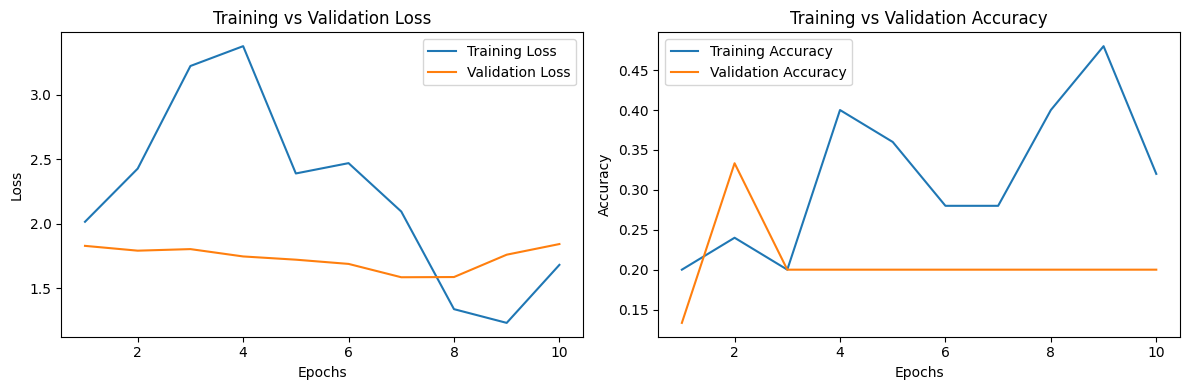

In [19]:
training_loss_vis(train_losses, val_losses, train_accuracies, val_accuracies)

In [20]:
test_model(resnet18_model, test_loader, criterion)

2 GPUs!


Testing: 100%|██████████| 2/2 [00:00<00:00, 11.55it/s, batch_accuracy=0.0000]

Test Loss: 1.8065, Test Accuracy: 0.2000


(1.8064749240875244, 0.2)